In [1]:
# install libriaries
# %pip install tensorflow keras opencv-python matplotlib seaborn scikit-learn numpy pandas tqdm

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

# print("Path to dataset files:", path)

In [3]:
# import libraries
import os
import time
import random
import cv2 as cv
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import pyttsx3
import threading
from tensorflow.keras.preprocessing.image import img_to_array

/home/wills/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/wills/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-08-10 04:49:49.461410: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 04:49:50.700408: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 04:49:51.346737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cu

In [4]:
# initialize list for images and label
data_train = "Face Expression Recognition Dataset/train/"
data_test = "Face Expression Recognition Dataset/test/"

# List for arrays
X_train = []
y_train = []
folders = ["surprise", "disgust", "happy", "sad", "fear", "neutral", "angry"]


In [5]:
# Load and append dataset for preprocessing
# Train folder
for folder in folders:
    train_path = data_train + folder
    print("\nCurrent folder:", train_path)
    for current_img in tqdm(os.listdir(train_path)):
        
        try:
            # Read and convert image to Grayscale
            img = cv.imread(train_path + "/" + current_img, cv.IMREAD_GRAYSCALE)
            
            # Display image
            # cv.imshow(f"Original Image {current_img}", img)
            # cv.waitKey(1000)
            
            # resize images
            img = cv.resize(img, (48, 48))
            
            # Show resized imaage
            # cv.imshow(f"Resized Image {current_img}", img)
            # cv.waitKey(1000)
            # cv.destroyAllWindows()
            
            X_train.append(img)
            y_train.append(folder)
            
        except:
            print(f"Error loading: {img}")
        
    print("Appended all images in '{}' folder successfully.".format(folder))
    
print(f"\nFinished processing all images in the folders successfully.")



Current folder: Face Expression Recognition Dataset/train/surprise


100%|██████████| 3205/3205 [00:05<00:00, 549.51it/s]


Appended all images in 'surprise' folder successfully.

Current folder: Face Expression Recognition Dataset/train/disgust


100%|██████████| 436/436 [00:00<00:00, 569.75it/s]


Appended all images in 'disgust' folder successfully.

Current folder: Face Expression Recognition Dataset/train/happy


100%|██████████| 7164/7164 [00:33<00:00, 215.20it/s]


Appended all images in 'happy' folder successfully.

Current folder: Face Expression Recognition Dataset/train/sad


100%|██████████| 4938/4938 [00:20<00:00, 238.57it/s]


Appended all images in 'sad' folder successfully.

Current folder: Face Expression Recognition Dataset/train/fear


100%|██████████| 4103/4103 [00:17<00:00, 232.83it/s]


Appended all images in 'fear' folder successfully.

Current folder: Face Expression Recognition Dataset/train/neutral


100%|██████████| 4982/4982 [00:19<00:00, 257.76it/s]


Appended all images in 'neutral' folder successfully.

Current folder: Face Expression Recognition Dataset/train/angry


100%|██████████| 3993/3993 [00:18<00:00, 220.00it/s]

Appended all images in 'angry' folder successfully.

Finished processing all images in the folders successfully.


In [6]:
# Convert to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

In [7]:
# Confirm length and splt into test and train
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=32)
print("\nShape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (23056, 48, 48)
Shape of y_train: (23056,)
Shape of X_test: (5765, 48, 48)
Shape of y_test: (5765,)


In [8]:
# Reshape and normalize
X_train = X_train.reshape(-1, 48, 48, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 48, 48, 1).astype('float32') / 255.0

In [9]:
# Encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

class_names = encoder.classes_
print("\nClasses:", class_names)

# Perform one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [10]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

In [11]:
"""Start building model"""
model = Sequential()

# First layer
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second layer 
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third layer 
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Fully connected layer 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))


# Output layer
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile with label smoothing
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

/home/wills/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-10 04:52:09.571940: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
print("Model Summary on version 3:")
model.summary()

Model Summary on version 3:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,472,711 (9.43 MB)

 Trainable params: 2,471,815 (9.43 MB)

 Non-trainable params: 896 (3.50 KB)

In [13]:
# Callbacks
callbacks = [
    ModelCheckpoint("emotions_model3.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

In [14]:
"""Train with new model (v3) on all data"""

# Use augementation with training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks=callbacks,
    verbose=1
)

/home/wills/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.2274 - loss: 2.5299

2025-08-10 04:57:56.613861: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 53130240 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from -inf to 0.31084, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 360s 492ms/step - accuracy: 0.2274 - loss: 2.5292 - val_accuracy: 0.3108 - val_loss: 1.7722 - learning_rate: 0.0010
Epoch 2/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.2989 - loss: 1.7854
Epoch 2: val_accuracy improved from 0.31084 to 0.37762, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 320s 444ms/step - accuracy: 0.2989 - loss: 1.7854 - val_accuracy: 0.3776 - val_loss: 1.6477 - learning_rate: 0.0010
Epoch 3/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.3350 - loss: 1.7246
Epoch 3: val_accuracy improved from 0.37762 to 0.41145, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 305s 420ms/step - accuracy: 0.3350 - loss: 1.7246 - val_accuracy: 0.4114 - val_loss: 1.6316 - learning_rate: 0.0010
Epoch 4/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.3653 - loss: 1.6797
Epoch 4: val_accuracy did not improve from 0.41145
721/721 ━━━━━━━━━━━━━━━━━━━━ 302s 419ms/step - accuracy: 0.3653 - loss: 1.6797 - val_accuracy: 0.3816 - val_loss: 1.6369 - learning_rate: 0.0010
Epoch 5/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.3832 - loss: 1.6533
Epoch 5: val_accuracy did not improve from 0.41145
721/721 ━━━━━━━━━━━━━━━━━━━━ 306s 425ms/step - accuracy: 0.3832 - loss: 1.6533 - val_accuracy: 0.3670 - val_loss: 1.6834 - learning_rate: 0.0010
Epoch 6/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3974 - loss: 1.6352
Epoch 6: val_accuracy improved from 0.41145 to 0.44128, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 330s 458ms/step - accuracy: 0.3974 - loss: 1.6351 - val_accuracy: 0.4413 - val_loss: 1.5421 - learning_rate: 0.0010
Epoch 7/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.4078 - loss: 1.6194
Epoch 7: val_accuracy did not improve from 0.44128
721/721 ━━━━━━━━━━━━━━━━━━━━ 356s 494ms/step - accuracy: 0.4078 - loss: 1.6194 - val_accuracy: 0.4271 - val_loss: 1.5849 - learning_rate: 0.0010
Epoch 8/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.4096 - loss: 1.6002
Epoch 8: val_accuracy improved from 0.44128 to 0.44735, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 308s 427ms/step - accuracy: 0.4096 - loss: 1.6002 - val_accuracy: 0.4474 - val_loss: 1.5516 - learning_rate: 0.0010
Epoch 9/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.4253 - loss: 1.5876
Epoch 9: val_accuracy improved from 0.44735 to 0.46921, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 304s 421ms/step - accuracy: 0.4253 - loss: 1.5876 - val_accuracy: 0.4692 - val_loss: 1.5129 - learning_rate: 0.0010
Epoch 10/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.4286 - loss: 1.5778
Epoch 10: val_accuracy improved from 0.46921 to 0.47823, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 303s 420ms/step - accuracy: 0.4286 - loss: 1.5778 - val_accuracy: 0.4782 - val_loss: 1.5022 - learning_rate: 0.0010
Epoch 11/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.4448 - loss: 1.5659
Epoch 11: val_accuracy improved from 0.47823 to 0.49211, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 302s 418ms/step - accuracy: 0.4448 - loss: 1.5659 - val_accuracy: 0.4921 - val_loss: 1.4706 - learning_rate: 0.0010
Epoch 12/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.4455 - loss: 1.5630
Epoch 12: val_accuracy did not improve from 0.49211
721/721 ━━━━━━━━━━━━━━━━━━━━ 304s 422ms/step - accuracy: 0.4455 - loss: 1.5630 - val_accuracy: 0.4559 - val_loss: 1.5103 - learning_rate: 0.0010
Epoch 13/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.4399 - loss: 1.5607
Epoch 13: val_accuracy improved from 0.49211 to 0.50130, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 303s 420ms/step - accuracy: 0.4399 - loss: 1.5607 - val_accuracy: 0.5013 - val_loss: 1.4577 - learning_rate: 0.0010
Epoch 14/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.4510 - loss: 1.5434
Epoch 14: val_accuracy improved from 0.50130 to 0.51223, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 321s 418ms/step - accuracy: 0.4510 - loss: 1.5435 - val_accuracy: 0.5122 - val_loss: 1.4506 - learning_rate: 0.0010
Epoch 15/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.4604 - loss: 1.5375
Epoch 15: val_accuracy did not improve from 0.51223
721/721 ━━━━━━━━━━━━━━━━━━━━ 302s 419ms/step - accuracy: 0.4604 - loss: 1.5375 - val_accuracy: 0.4725 - val_loss: 1.4859 - learning_rate: 0.0010
Epoch 16/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.4625 - loss: 1.5292
Epoch 16: val_accuracy improved from 0.51223 to 0.53044, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 305s 423ms/step - accuracy: 0.4625 - loss: 1.5292 - val_accuracy: 0.5304 - val_loss: 1.4165 - learning_rate: 0.0010
Epoch 17/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.4632 - loss: 1.5226
Epoch 17: val_accuracy improved from 0.53044 to 0.53859, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 326s 428ms/step - accuracy: 0.4632 - loss: 1.5226 - val_accuracy: 0.5386 - val_loss: 1.4008 - learning_rate: 0.0010
Epoch 18/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.4725 - loss: 1.5164
Epoch 18: val_accuracy did not improve from 0.53859
721/721 ━━━━━━━━━━━━━━━━━━━━ 300s 416ms/step - accuracy: 0.4725 - loss: 1.5164 - val_accuracy: 0.5200 - val_loss: 1.4278 - learning_rate: 0.0010
Epoch 19/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.4737 - loss: 1.5128
Epoch 19: val_accuracy did not improve from 0.53859
721/721 ━━━━━━━━━━━━━━━━━━━━ 299s 415ms/step - accuracy: 0.4737 - loss: 1.5128 - val_accuracy: 0.4801 - val_loss: 1.4983 - learning_rate: 0.0010
Epoch 20/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.4739 - loss: 1.5078
Epoch 20: val_accuracy did not improve from 0.53859

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
721/721 ━━━━━━━━━━━━━━━━━━━━ 309s 428ms/step - accuracy: 0.4739

721/721 ━━━━━━━━━━━━━━━━━━━━ 311s 413ms/step - accuracy: 0.4904 - loss: 1.4848 - val_accuracy: 0.5461 - val_loss: 1.3808 - learning_rate: 2.0000e-04
Epoch 22/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.4984 - loss: 1.4577
Epoch 22: val_accuracy improved from 0.54605 to 0.55160, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 301s 418ms/step - accuracy: 0.4984 - loss: 1.4577 - val_accuracy: 0.5516 - val_loss: 1.3567 - learning_rate: 2.0000e-04
Epoch 23/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.5037 - loss: 1.4487
Epoch 23: val_accuracy improved from 0.55160 to 0.55785, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 310s 430ms/step - accuracy: 0.5037 - loss: 1.4487 - val_accuracy: 0.5578 - val_loss: 1.3574 - learning_rate: 2.0000e-04
Epoch 24/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.5131 - loss: 1.4496
Epoch 24: val_accuracy did not improve from 0.55785
721/721 ━━━━━━━━━━━━━━━━━━━━ 301s 417ms/step - accuracy: 0.5131 - loss: 1.4496 - val_accuracy: 0.5559 - val_loss: 1.3594 - learning_rate: 2.0000e-04
Epoch 25/25
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.5140 - loss: 1.4463
Epoch 25: val_accuracy improved from 0.55785 to 0.56184, saving model to emotions_model3.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 304s 422ms/step - accuracy: 0.5140 - loss: 1.4463 - val_accuracy: 0.5618 - val_loss: 1.3531 - learning_rate: 2.0000e-04


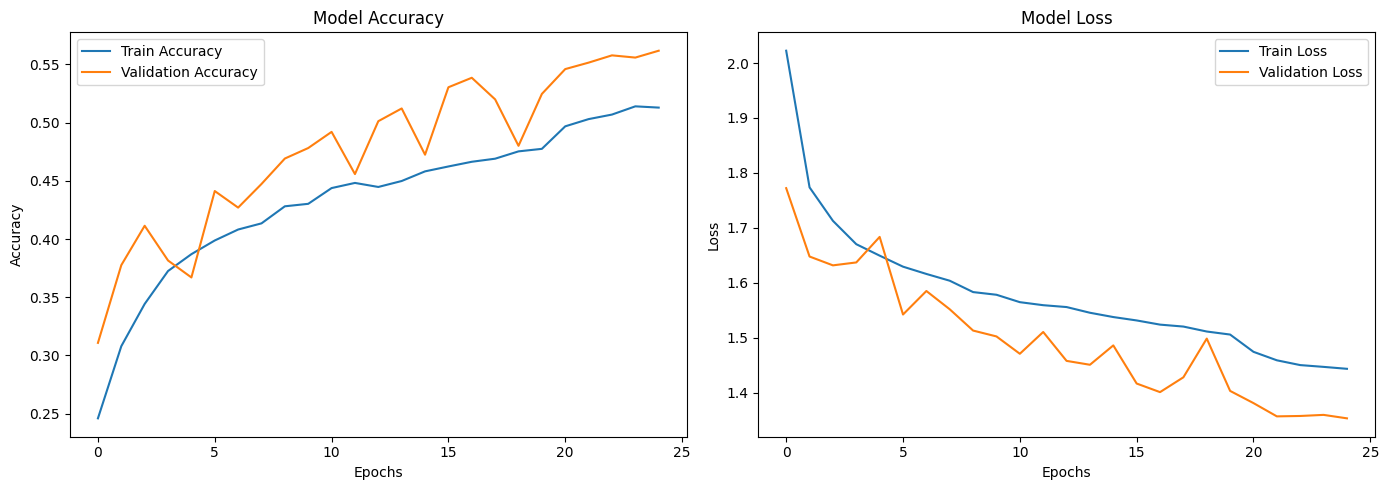

In [15]:
# Metrics graphs
plt.figure(figsize=(14,5))

# plot accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


2025-08-10 07:24:19.792837: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 53130240 exceeds 10% of free system memory.


181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.5073 - loss: 1.4469

Test Accuracy: 50.63%


2025-08-10 07:24:34.504868: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 53130240 exceeds 10% of free system memory.


181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step
Classification Report:

              precision    recall  f1-score   support

       angry       0.41      0.41      0.41       853
     disgust       0.00      0.00      0.00        77
        fear       0.31      0.09      0.14       787
       happy       0.67      0.83      0.74      1416
     neutral       0.44      0.54      0.49       986
         sad       0.36      0.33      0.34       992
    surprise       0.57      0.71      0.63       654

    accuracy                           0.51      5765
   macro avg       0.39      0.42      0.39      5765
weighted avg       0.47      0.51      0.48      5765



/home/wills/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wills/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wills/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


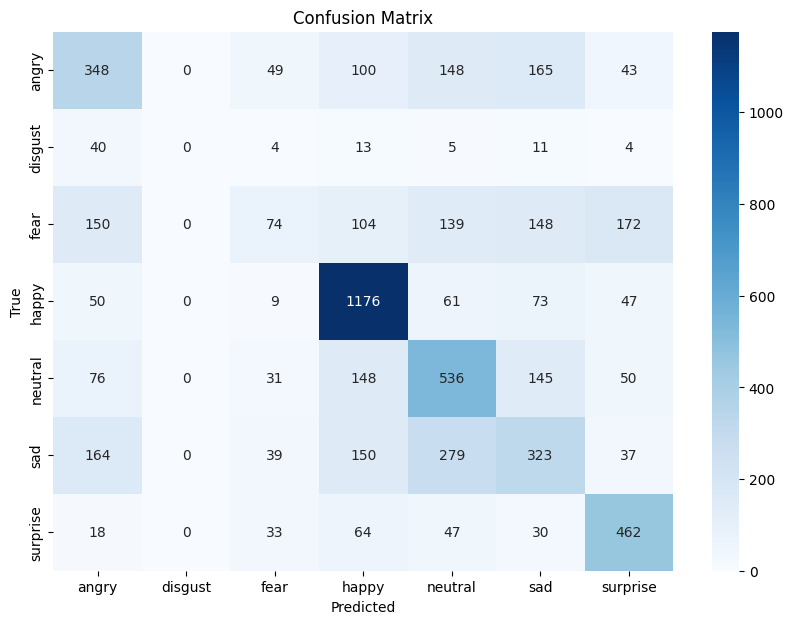

In [ ]:
#load model and predict
model = load_model("emotions_model3.h5")

#Evaluation on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

#Predict labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


# classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

# plot confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

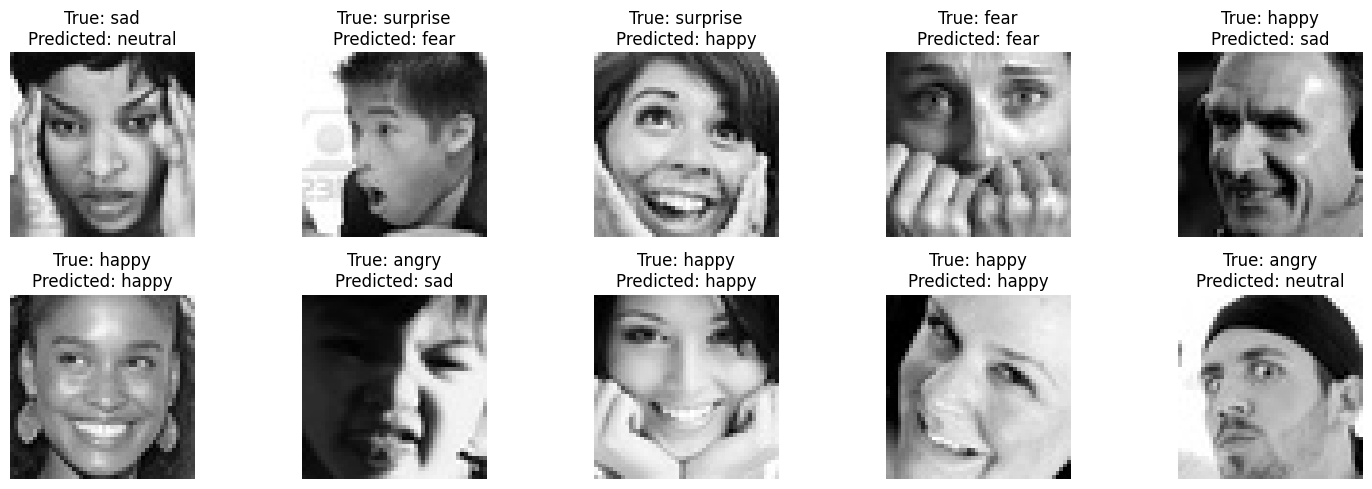

In [17]:
# Display 10 random test images with predicted and actual emotions
plt.figure(figsize=(15, 5))
for i in range(10):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx].reshape(48, 48)
    true_label = encoder.classes_[y_true[idx]]
    pred_label = encoder.classes_[y_pred_classes[idx]]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPredicted: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    data_test,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode='categorical'
)

Found 70 images belonging to 7 classes.


In [19]:
def predict_emotion(img_path):
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

    if img is None:
        print("Error: File not found. Check the path or file format.")
        return None

    img = cv.resize(img, (48, 48))
    img = img.reshape(1, 48, 48, 1) / 255.0

    prediction = model.predict(img)
    
    # Directly hardcoded class labels
    class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    predicted_label = class_labels[np.argmax(prediction)]

    return predicted_label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


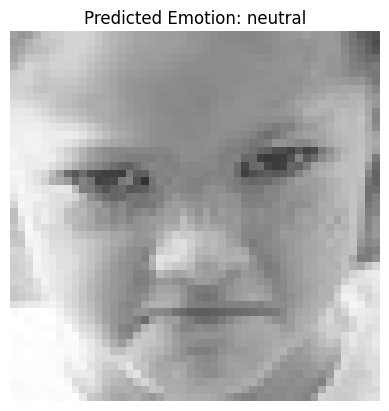

In [20]:
def show_image_with_prediction(img_path):
    emotion = predict_emotion(img_path)
    if emotion:
        img = cv.imread(img_path)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(f"Predicted Emotion: {emotion}")
        plt.axis('off')
        plt.show()

# Use it:
show_image_with_prediction("Face Expression Recognition Dataset/test/angry/angry_test_03.jpg")


In [21]:
# from tensorflow.keras.models import load_model
# import pyttsx3
# import cv2 as cv
# import numpy as np
# import time
# import threading

# # Load emotion detection model
# model = load_model("emotions_model.h5")
# emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# # Initialize TTS
# engine = pyttsx3.init()
# engine.setProperty('rate', 160)

# # Function to run speech in background
# def speak_emotion(emotion):
#     def _speak():
#         if emotion_labels == "Fear":
#             engine.say(f"You look {emotion.lower()}ful")  # fearful
#         elif emotion_labels == "Surprise":
#             engine.say(f"You look {emotion.lower()}d")    # surprised
#         else:
#             engine.say(f"You look {emotion.lower()}")
#         engine.runAndWait()
        
#     threading.Thread(target=_speak, daemon=True).start()


# # Haar Cascade for face detection
# face_classifier = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")

# # Video capture
# cap = cv.VideoCapture(0)

# last_spoken_emotion = None
# last_spoken_time = 0
# speak_interval = 7  # 7 seconds

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break
    
#     #flip video output horizontally
#     frame = cv.flip(frame, 1)
    
#     # Convert to grayscale
#     frame2gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

#     # Detect faces
#     faces = face_classifier.detectMultiScale(frame2gray, scaleFactor=1.2, minNeighbors=4)

#     for (x, y, w, h) in faces:
#         roi = frame2gray[y:y+h, x:x+w]
#         roi_resized = cv.resize(roi, (48, 48))
#         roi_normalized = roi_resized / 255.0
#         roi_reshaped = np.reshape(roi_normalized, (1, 48, 48, 1))

#         # Prediction
#         prediction = model.predict(roi_reshaped, verbose=0)
#         emotion_index = np.argmax(prediction)
#         predicted_emotion = emotion_labels[emotion_index]
#         confidence = np.max(prediction) * 100

#         # Draw rectangle around face
#         color = (0, 0, 255) if predicted_emotion == 'Happy' else (255, 0, 0)
#         cv.rectangle(frame, (x, y), (x + w, y + h), color, 2)

#         label = f"{predicted_emotion} ({confidence:.1f}%)"
#         cv.putText(frame, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
#         # Speak if detected another emotion
#         current_time = time.time()
#         if (predicted_emotion != last_spoken_emotion) or (current_time - last_spoken_time > speak_interval):
#             speak_emotion(predicted_emotion)
#             last_spoken_emotion = predicted_emotion
#             last_spoken_time = current_time
            
            
#     cv.imshow('Emotion Detection', frame)

#     if cv.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv.destroyAllWindows()
